🚀 运行设备: cuda

>>> [1/7] 加载与划分数据集...
   - 训练集 (Train): 1525
   - 验证集 (Val):   268
   - 测试集 (Test):  451

>>> [2/7] 构建词表 (仅基于训练集)...

>>> [3/7] 初始化模型 (ResNet Frozen)...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



>>> [4/7] 开始训练...
Epoch 01 | Train Loss: 4.3047 | Val Loss: 2.8035 | Val Acc: 31.33%
         -> 🌟 Val Loss 降低，最佳模型已保存！
Epoch 02 | Train Loss: 3.0253 | Val Loss: 2.5070 | Val Acc: 35.62%
         -> 🌟 Val Loss 降低，最佳模型已保存！
Epoch 03 | Train Loss: 2.6424 | Val Loss: 2.3882 | Val Acc: 39.48%
         -> 🌟 Val Loss 降低，最佳模型已保存！
Epoch 04 | Train Loss: 2.3943 | Val Loss: 2.6069 | Val Acc: 34.33%
         -> Val Loss 未降低 (1/8)
Epoch 05 | Train Loss: 2.1075 | Val Loss: 2.2770 | Val Acc: 37.77%
         -> 🌟 Val Loss 降低，最佳模型已保存！
Epoch 06 | Train Loss: 1.9124 | Val Loss: 2.0505 | Val Acc: 41.20%
         -> 🌟 Val Loss 降低，最佳模型已保存！
Epoch 07 | Train Loss: 1.7123 | Val Loss: 2.0466 | Val Acc: 40.34%
         -> 🌟 Val Loss 降低，最佳模型已保存！
Epoch 08 | Train Loss: 1.5630 | Val Loss: 1.9606 | Val Acc: 42.92%
         -> 🌟 Val Loss 降低，最佳模型已保存！
Epoch 09 | Train Loss: 1.4504 | Val Loss: 1.9109 | Val Acc: 47.64%
         -> 🌟 Val Loss 降低，最佳模型已保存！
Epoch 10 | Train Loss: 1.2904 | Val Loss: 1.9061 | Val Acc: 43.35%


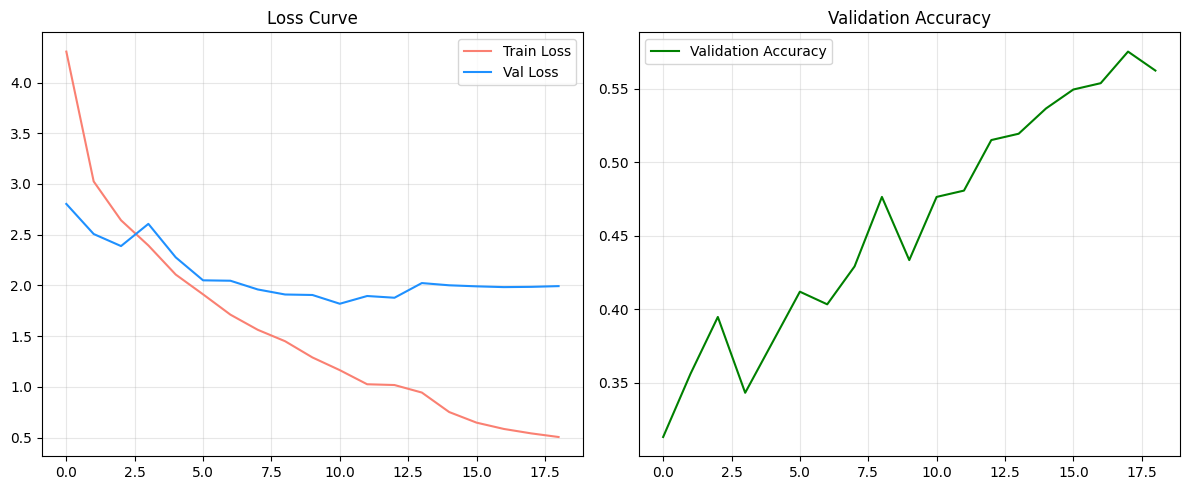

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from datasets import load_dataset
from collections import Counter
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import math

# ================= 1. 全局配置 =================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 运行设备: {DEVICE}")

# 超参数
BATCH_SIZE = 32
EPOCHS = 40             # 设置较大，依靠早停停止
LEARNING_RATE = 1e-3    # 冻结骨干后LR可以稍大
MAX_SEQ_LEN = 20
VOCAB_SIZE = 2500
PATIENCE = 8            # 早停耐心值
OUTPUT_DIR = "./output"
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)
BEST_MODEL_PATH = os.path.join(OUTPUT_DIR, 'best_model.pth')

# ================= 2. 数据准备与划分 =================
print("\n>>> [1/7] 加载与划分数据集...")
raw_dataset = load_dataset("flaviagiammarino/vqa-rad")
full_train_data = raw_dataset['train']
test_data = raw_dataset['test']

# --- 核心：划分验证集 (85% Train, 15% Val) ---
torch.manual_seed(42)
val_ratio = 0.15
val_size = int(len(full_train_data) * val_ratio)
train_size = len(full_train_data) - val_size

train_subset, val_subset = random_split(full_train_data, [train_size, val_size])

print(f"   - 训练集 (Train): {len(train_subset)}")
print(f"   - 验证集 (Val):   {len(val_subset)}")
print(f"   - 测试集 (Test):  {len(test_data)}")

# ================= 3. 构建词表 =================
print("\n>>> [2/7] 构建词表 (仅基于训练集)...")
def build_vocab(dataset):
    words = []
    for item in dataset:
        words.extend(item['question'].lower().replace("?", "").split())
    word_counts = Counter(words)
    vocab = {word: i+2 for i, (word, count) in enumerate(word_counts.most_common(VOCAB_SIZE))}
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    
    answers = [str(item['answer']).lower() for item in dataset]
    ans_counts = Counter(answers)
    # 选取 Top 450 答案
    ans_vocab = {ans: i for i, (ans, c) in enumerate(ans_counts.most_common(450))}
    return vocab, ans_vocab

q_vocab, ans_vocab = build_vocab(train_subset)
id2answer = {v: k for k, v in ans_vocab.items()} 
NUM_CLASSES = len(ans_vocab)

# ================= 4. 数据增强与 Dataset =================
train_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.RandomRotation(15),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class VQADataset(Dataset):
    def __init__(self, data, q_vocab, ans_vocab, transform=None):
        self.data = data
        self.q_vocab = q_vocab
        self.ans_vocab = ans_vocab
        self.transform = transform

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image'].convert('RGB')
        question = item['question'].lower().replace("?", "").split()
        ans_text = str(item['answer']).lower()
        
        if self.transform:
            image = self.transform(image)
        
        q_indices = [self.q_vocab.get(w, 1) for w in question][:MAX_SEQ_LEN]
        q_indices += [0] * (MAX_SEQ_LEN - len(q_indices))
        
        label = self.ans_vocab.get(ans_text, -1)
        is_closed = 1 if ans_text in ['yes', 'no'] else 0
        
        return image, torch.tensor(q_indices), torch.tensor(label), is_closed

train_loader = DataLoader(VQADataset(train_subset, q_vocab, ans_vocab, train_transform), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(VQADataset(val_subset, q_vocab, ans_vocab, val_test_transform), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(VQADataset(test_data, q_vocab, ans_vocab, val_test_transform), batch_size=BATCH_SIZE, shuffle=False)

# ================= 5. 模型定义 =================
print("\n>>> [3/7] 初始化模型 (ResNet Frozen)...")

class MedVQAModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(MedVQAModel, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        for param in resnet.parameters():
            param.requires_grad = False
        self.img_encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.img_fc = nn.Linear(2048, hidden_dim)
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.2)
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, img, question):
        with torch.no_grad():
            img_feat = self.img_encoder(img).view(img.size(0), -1)
        img_feat = self.img_fc(img_feat)
        
        embeds = self.embedding(question)
        _, (h_n, _) = self.lstm(embeds)
        text_feat = h_n[-1]
        
        combined = torch.cat((img_feat, text_feat), dim=1)
        output = self.classifier(combined)
        return output

# ================= 6. 训练引擎 =================
def train_engine():
    model = MedVQAModel(len(q_vocab)+2, 300, 512, NUM_CLASSES).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    print("\n>>> [4/7] 开始训练...")
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for imgs, qs, labels, _ in train_loader:
            imgs, qs, labels = imgs.to(DEVICE), qs.to(DEVICE), labels.to(DEVICE)
            valid = labels != -1
            if not valid.any(): continue
            
            optimizer.zero_grad()
            outputs = model(imgs[valid], qs[valid])
            loss = criterion(outputs, labels[valid])
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for imgs, qs, labels, _ in val_loader:
                imgs, qs, labels = imgs.to(DEVICE), qs.to(DEVICE), labels.to(DEVICE)
                valid = labels != -1
                if not valid.any(): continue
                outputs = model(imgs[valid], qs[valid])
                loss = criterion(outputs, labels[valid])
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels[valid].cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
        val_acc = accuracy_score(all_labels, all_preds)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        scheduler.step(avg_val_loss)
        
        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2%}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            print("         -> 🌟 Val Loss 降低，最佳模型已保存！")
        else:
            epochs_no_improve += 1
            print(f"         -> Val Loss 未降低 ({epochs_no_improve}/{PATIENCE})")
            
        if epochs_no_improve >= PATIENCE:
            print(f"\n✋ 早停触发！停止训练。")
            break
    return history

history = train_engine()

# ================= 7. 绘图 =================
print("\n>>> [5/7] 绘制训练曲线...")
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(history['train_loss'], label='Train Loss', color='salmon')
    ax[0].plot(history['val_loss'], label='Val Loss', color='dodgerblue')
    ax[0].set_title('Loss Curve'); ax[0].legend(); ax[0].grid(True, alpha=0.3)
    
    ax[1].plot(history['val_acc'], label='Validation Accuracy', color='green')
    ax[1].set_title('Validation Accuracy'); ax[1].legend(); ax[1].grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

plot_history(history)




>>> [6/7] 正在使用最佳模型进行测试集评估...
有效测试样本数: 334

🏆 最终测试集成绩单 (Best Model)
总体准确率 (Overall Acc):  48.50%
总体 F1 分数 (Overall F1): 0.4741
----------------------------------------
✅ 闭合问题 (Yes/No): 63.35%  (样本数: 251)
🗣️ 开放问题 (Open):   3.61%  (样本数: 83)

>>> [7/7] 随机抽取 6 个测试样本可视化...


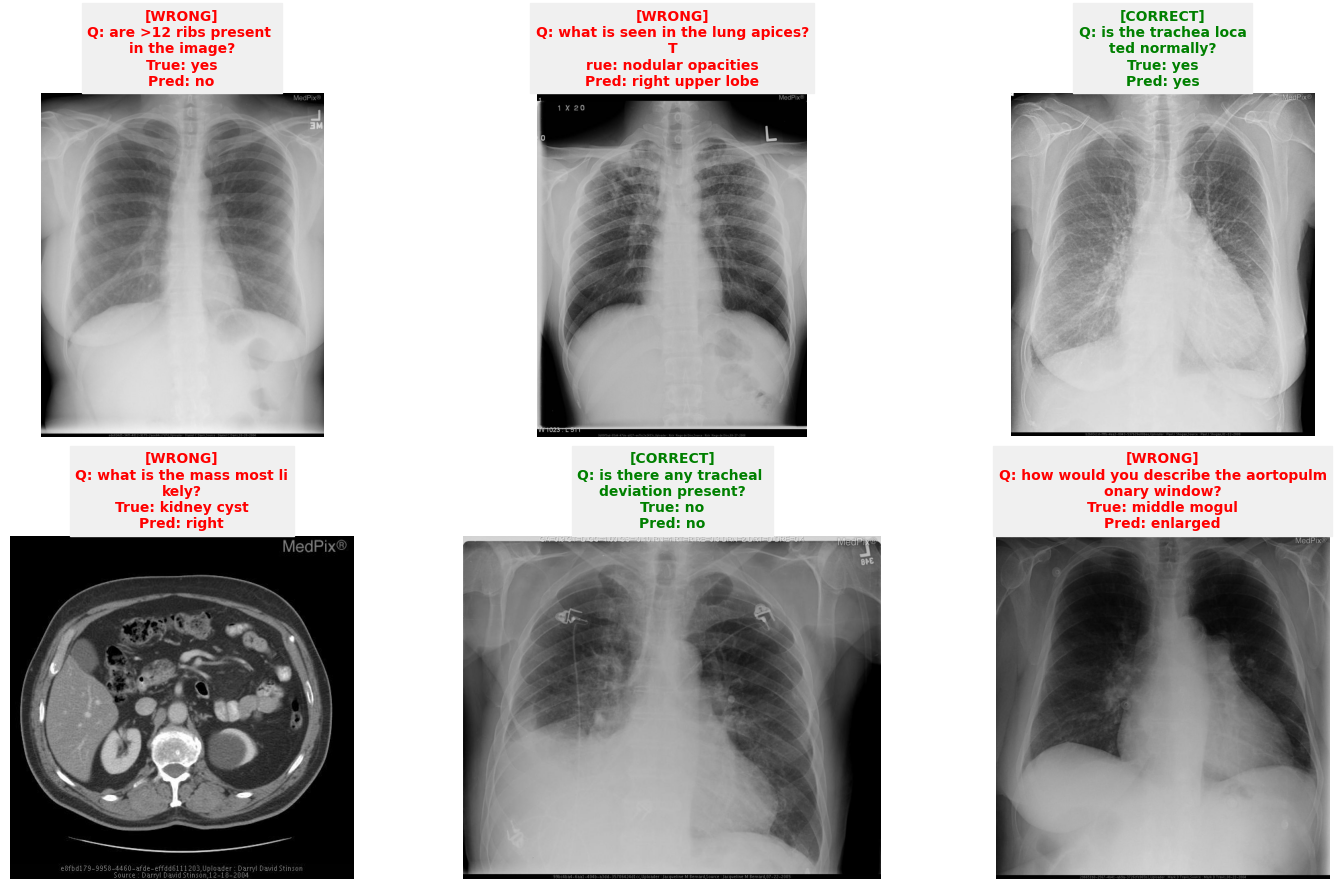

In [12]:
# ================= 8. 最终测试 =================
print("\n>>> [6/7] 正在使用最佳模型进行测试集评估...")
final_model = MedVQAModel(len(q_vocab)+2, 300, 512, NUM_CLASSES).to(DEVICE)
final_model.load_state_dict(torch.load(BEST_MODEL_PATH))
final_model.eval()

all_preds, all_labels, all_types = [], [], []

with torch.no_grad():
    for imgs, qs, labels, types in test_loader:
        imgs, qs, labels, types = imgs.to(DEVICE), qs.to(DEVICE), labels.to(DEVICE), types.to(DEVICE)
        valid = labels != -1
        if not valid.any(): continue
        outputs = final_model(imgs[valid], qs[valid])
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels[valid].cpu().numpy())
        all_types.extend(types[valid].cpu().numpy()) 

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_types = np.array(all_types)

print(f"有效测试样本数: {len(all_labels)}")
total_acc = accuracy_score(all_labels, all_preds)
total_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

closed_mask = (all_types == 1)
closed_acc = accuracy_score(all_labels[closed_mask], all_preds[closed_mask]) if np.sum(closed_mask) > 0 else 0
closed_count = np.sum(closed_mask)

open_mask = (all_types == 0)
open_acc = accuracy_score(all_labels[open_mask], all_preds[open_mask]) if np.sum(open_mask) > 0 else 0
open_count = np.sum(open_mask)

print(f"\n{'='*40}")
print(f"🏆 最终测试集成绩单 (Best Model)")
print(f"{'='*40}")
print(f"总体准确率 (Overall Acc):  {total_acc:.2%}")
print(f"总体 F1 分数 (Overall F1): {total_f1:.4f}")
print(f"----------------------------------------")
print(f"✅ 闭合问题 (Yes/No): {closed_acc:.2%}  (样本数: {closed_count})")
print(f"🗣️ 开放问题 (Open):   {open_acc:.2%}  (样本数: {open_count})")
print(f"{'='*40}")

# ================= 9. 可视化 =================
print("\n>>> [7/7] 随机抽取 6 个测试样本可视化...")

def visualize_test_samples(dataset, model, num_samples=6):
    indices = random.sample(range(len(dataset)), num_samples)
    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(15, 9))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        item = dataset[idx]
        raw_image = item['image'].convert('RGB')
        question = item['question']
        true_ans = str(item['answer']).lower()
        
        img_tensor = val_test_transform(raw_image).unsqueeze(0).to(DEVICE)
        q_tokens = question.lower().replace("?", "").split()
        q_ids = [q_vocab.get(w, 1) for w in q_tokens][:MAX_SEQ_LEN]
        q_ids += [0] * (MAX_SEQ_LEN - len(q_ids))
        q_tensor = torch.tensor([q_ids]).to(DEVICE)
        
        with torch.no_grad():
            out = model(img_tensor, q_tensor)
            pred_idx = torch.argmax(out, dim=1).item()
            pred_ans = id2answer.get(pred_idx, "<unk>")
        
        ax = axes[i]
        ax.imshow(raw_image)
        ax.axis('off')
        
        if pred_ans == true_ans:
            color = 'green'; tag = "[CORRECT]"
        else:
            color = 'red'; tag = "[WRONG]"
        
        title = f"{tag}\nQ: {question}\nTrue: {true_ans}\nPred: {pred_ans}"
        if len(title) > 60:
            mid = len(title) // 2
            title = title[:mid] + "\n" + title[mid:]
            
        ax.set_title(title, fontsize=10, color=color, fontweight='bold', backgroundcolor='#f0f0f0')

    plt.tight_layout()
    plt.show()

visualize_test_samples(test_data, final_model)